# Bitcoin Prediction

In this notebook we will try to predict the price of bitcoin.

To do this, we will create a recurrent neural network with LSTM layers.
We will compare the results with those obtained using classical forecasting methods such as fbProphet.

In [5]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import numpy as np

#keras
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator

#sklearn
from sklearn.preprocessing import MinMaxScaler

#display
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
sns.set_theme()

#statsmodels
from statsmodels.tsa.arima.model import ARIMA

We retrieve bitcoin closing prices since September 2014 using the yahoo API.

In [9]:
#btc_data = pdr.DataReader('BTC-USD','yahoo',start=datetime.datetime(2014, 9, 16), 
#                          end=datetime.datetime(2021, 4, 2))
#btc_data.columns = btc_data.columns.droplevel(1)
btc_data = pd.read_csv('BTC-USD.csv')
btc_data = btc_data.set_index('Date')
btc_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


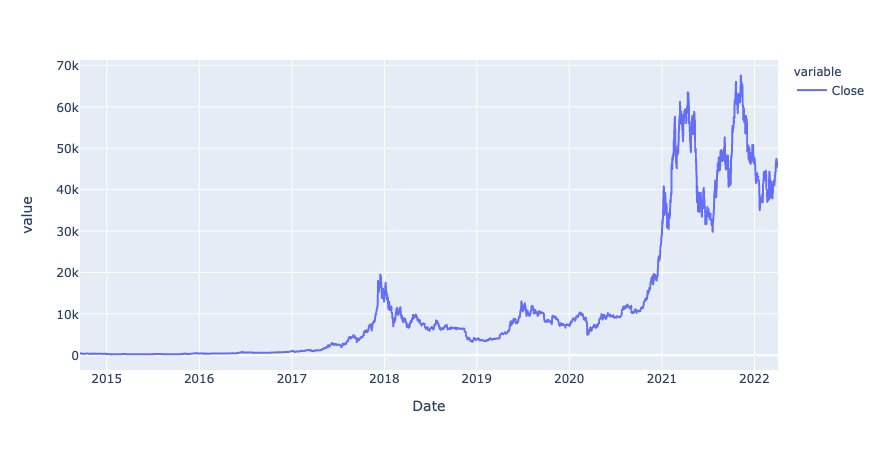

In [10]:
btc_data['Close'].plot()

## Extract data

We focus for now on the closing price of BTC-USD.

In [11]:
# split data
PREDICTIONS_DAYS = 700
N_FEATURES = 1
FEATURE = 'Close'
WINDOW_SIZE = 365
BATCH_SIZE = 8

# split data frames into train and test
df_train = btc_data.iloc[:len(btc_data)-PREDICTIONS_DAYS]
df_val = btc_data.iloc[len(btc_data)-PREDICTIONS_DAYS:]
df_test = btc_data.iloc[len(btc_data)-PREDICTIONS_DAYS-WINDOW_SIZE:]

# values
train_values = df_train[FEATURE].values
val_values = df_val[FEATURE].values
test_values = df_test[FEATURE].values
all_values = btc_data[FEATURE].values

series_train= np.reshape(train_values, (len(train_values), N_FEATURES))
series_val = np.reshape(val_values, (len(val_values), N_FEATURES))
series_test = np.reshape(test_values, (len(test_values), N_FEATURES))
series = np.reshape(all_values, (len(all_values), N_FEATURES))
print(series_train.shape, series_val.shape, series_test.shape)

sc = MinMaxScaler()
series_train = sc.fit_transform(series_train)
series_val = sc.transform(series_val)
series_test = sc.transform(series_test)

# define generator
train_generator = TimeseriesGenerator(series_train, series_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = TimeseriesGenerator(series_val, series_val, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
test_generator = TimeseriesGenerator(series_test, series_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)

(2057, 1) (700, 1) (1065, 1)


## Training

In [12]:
def build_model():
    # Initialising the RNN
    model = Sequential()

    # Adding the input layer and the LSTM layer
    model.add(LSTM(units = 200, input_shape = (WINDOW_SIZE, 1), return_sequences=True))
    
    #Dropout to avoid overfiting
    model.add(Dropout(0.25))
    
    # Adding a second LSTM layer
    model.add(LSTM(units = 100))
    
    #Dropout to avoid overfiting
    model.add(Dropout(0.25))
    
    # Adding the output layer
    model.add(Dense(units = 1, activation = "linear"))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'MSE', metrics=["mae"])

    # Fitting the RNN to the Training set
    model.summary()

    return model

In [13]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 200)          161600    
_________________________________________________________________
dropout (Dropout)            (None, 365, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
212/212 [==============================] - 50s 227ms/step - loss: 0.0142 - mae: 0.0758 - val_loss: 0.4753 - val_mae: 0.6291
Epoch 2/10
212/212 [==============================] - 47s 221ms/step - loss: 0.0028 - mae: 0.0363 - val_loss: 0.4398 - val_mae: 0.6159
Epoch 3/10
212/212 [==============================] - 47s 221ms/step - loss: 0.0017 - mae: 0.0277 - val_loss: 0.2552 - val_mae: 0.4530
Epoch 4/10
212/212 [==============================] - 46s 216ms/step - loss: 0.0019 - mae: 0.0288 - val_loss: 0.2663 - val_mae: 0.4758
Epoch 5/10
212/212 [==============================] - 48s 227ms/step - loss: 0.0018 - mae: 0.0266 - val_loss: 0.2407 - val_mae: 0.4553
Epoch 6/10
212/212 [==============================] - 45s 214ms/step - loss: 0.0018 - mae: 0.0293 - val_loss: 0.2196 - val_mae: 0.4213
Epoch 7/10
212/212 [==============================] - 45s 214ms/step - loss: 0.0017 - mae: 0.0253 - val_loss: 0.2440 - val_mae: 0.4379
Epoch 8/10
212/212 [==============================] - 5

In [15]:
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()
  plt.yscale("log")
  plt.show()

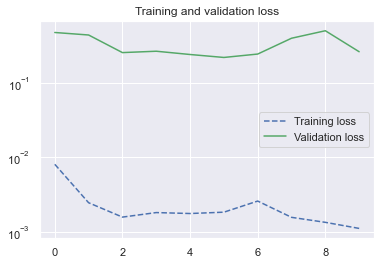

In [16]:
plot_training_analysis(history)

In [17]:
def join_df(train_datetime, train_values, test_datetime, test_values):
    test_values = np.reshape(test_values, (len(test_values)))
    datetime = np.append(train_datetime, test_datetime, axis=0)
    values = np.append(train_values, test_values, axis=0)
    label_train = ['train' for x in train_values]
    label_test = ['test' for x in test_values]
    label = np.append(label_train, label_test, axis=0)
    df_pred = pd.DataFrame(data = np.transpose([datetime, label, values]), columns = ["datetime", "label", "value"])
    df_pred['datetime'] = pd.to_datetime(df_pred['datetime'])
    df_pred.set_index('datetime', inplace=True)
    df_pred = df_pred.astype({"value" : "float32"})
    return df_pred

In [18]:
y_test_pred = sc.inverse_transform(model.predict(test_generator))
print(y_test_pred.shape)
df_pred = join_df(df_train.index, train_values, df_val.index, y_test_pred[:,0])
df_pred.head()

(700, 1)


,label,value
datetime,,
2014-09-17,train,457.334015
2014-09-18,train,424.440002
2014-09-19,train,394.795990
2014-09-20,train,408.903992
2014-09-21,train,398.821014


In [19]:
df_test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-06,5791.693359,5802.957520,5653.687500,5746.807129,5746.807129,15737171804
2019-05-07,5745.599121,5988.178223,5741.395996,5829.501465,5829.501465,18026409033
2019-05-08,5849.481445,5989.980957,5794.715820,5982.457520,5982.457520,15320605300
2019-05-09,5982.316406,6183.039063,5982.316406,6174.528809,6174.528809,16784645411
2019-05-10,6175.822754,6434.617676,6161.519043,6378.849121,6378.849121,19419875368
...,...,...,...,...,...,...
2022-03-31,47062.148438,47512.027344,45390.539063,45538.675781,45538.675781,33327427106
2022-04-01,45554.164063,46616.242188,44403.140625,46281.644531,46281.644531,38162644287
2022-04-02,46285.500000,47028.281250,45782.511719,45868.949219,45868.949219,29336594194


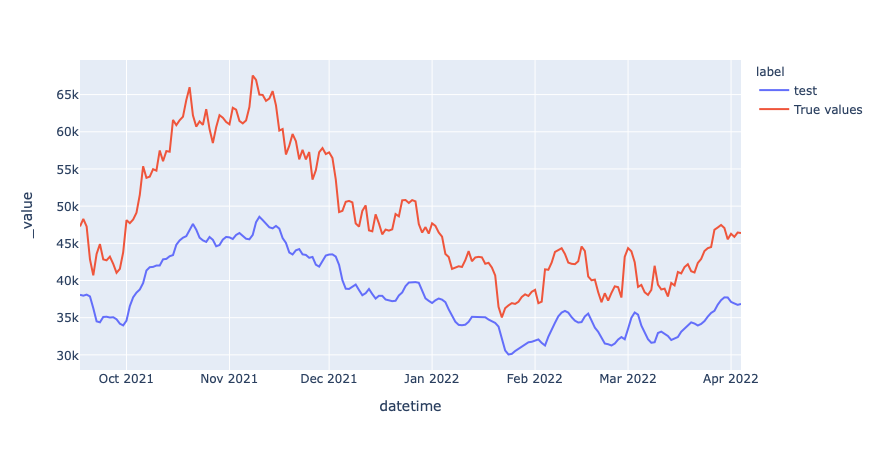

In [20]:
num_val = 200
fig = px.line(df_pred[-num_val:], color = "label")
fig.add_trace(go.Scatter(x=df_test[-num_val:].index, 
                         y = test_values[-num_val:],
                        name = 'True values'))
fig.show()

## Forecasting avec ensemble de test

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 365, 200)          161600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 365, 200)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
212/212 [==============================] - 48s 216ms/step - loss: 0.0092 - mae: 0.0619
Epoch 2/5
212/212

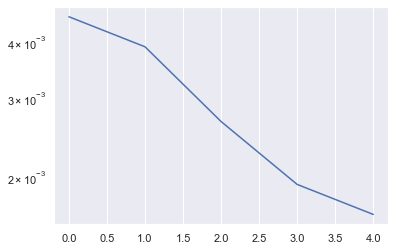

In [21]:
sc = MinMaxScaler()
series_forecasting = sc.fit_transform(train_values.reshape(-1, 1))
generator_forecasting = TimeseriesGenerator(series_forecasting, series_forecasting, 
                                            length=WINDOW_SIZE, batch_size=8)
# fit model
model = build_model()
history = model.fit(generator_forecasting, epochs=5, verbose=1)
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()

In [22]:
def forecast_lstm(series_forecasting, nb_val):
    predictions = list()
    series_f = series_forecasting.copy()
    for i in range(nb_val):
        prediction = model.predict(np.expand_dims(series_f[-WINDOW_SIZE:], axis=0))
        yhat = prediction[-1]
        #print(sc.inverse_transform([yhat])[0][0])
        #Append forecasted value
        predictions.append(yhat)
        series_f = np.append(series_f, [yhat], axis=0)
    
    return predictions

In [30]:
# datetimes of train and test dataset
datetimes = df_train.index
dt_forecast = pd.date_range(start = pd.to_datetime(datetimes[-1])+ datetime.timedelta(days=1), end=datetime.datetime(2021, 5, 8))

# Number of value to forecast
NB_VAL = len(dt_forecast)

# compute predictions
predictions_lstm = forecast_lstm(series_forecasting, NB_VAL)

# inverse transformation of MinMaxScaler
predictions_lstm = sc.inverse_transform(predictions_lstm)

# join train df and test predicted df
df_forecast_lstm = join_df(df_train.index, train_values, dt_forecast, predictions_lstm)
df_forecast_lstm.tail(5)

,label,value
datetime,,
2021-05-04,test,18665.369141
2021-05-05,test,18665.371094
2021-05-06,test,18665.369141
2021-05-07,test,18665.369141
2021-05-08,test,18665.369141


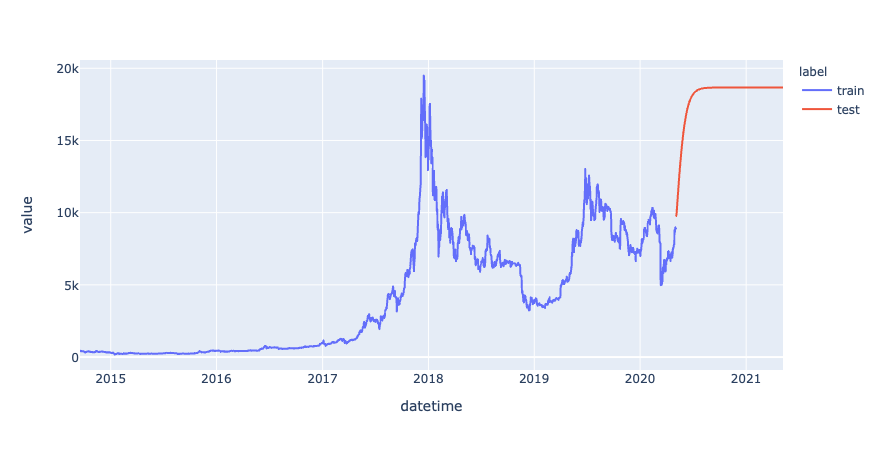

In [31]:
fig = px.line(df_forecast_lstm, x=df_forecast_lstm.index, y="value", color="label")
fig.show()

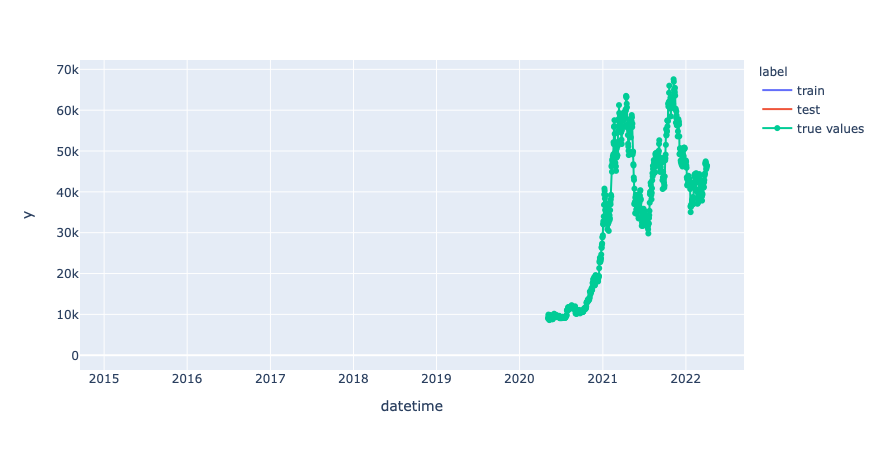

In [32]:
date=df_forecast_lstm.index

# Create traces
fig = px.line(df_forecast_lstm,x=df_forecast_lstm.index, y=df_forecast_lstm.value.values, color='label')
fig.add_trace(go.Scatter(x=df_val.index, y=df_val.Close,
                    mode='lines+markers', name= "true values"))

fig.show()

## Forecasting sans ensemble de test

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 365, 200)          161600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 365, 200)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
299/299 [==============================] - 67s 215ms/step - loss: 0.0155 - mae: 0.0601
Epoch 2/5
299/299

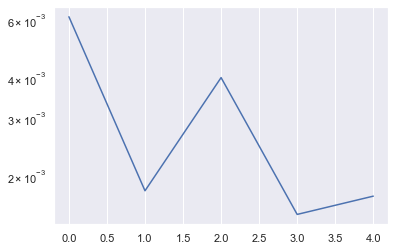

In [33]:
sc = MinMaxScaler()
series_forecasting = sc.fit_transform(all_values.reshape(-1, 1))
generator_forecasting = TimeseriesGenerator(series_forecasting, series_forecasting, 
                                            length=WINDOW_SIZE, batch_size=8)
# fit model
model = build_model()
history = model.fit(generator_forecasting, epochs=5, verbose=1)
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()

In [38]:
# datetimes of train and test dataset
datetimes = btc_data.index
dt_forecast = pd.date_range(start = pd.to_datetime(datetimes[-1])+ datetime.timedelta(days=1), end=datetime.datetime(2023, 5, 8))

# Number of value to forecast
NB_VAL = len(dt_forecast)

# compute predictions
predictions_lstm = forecast_lstm(series_forecasting, NB_VAL)

# inverse transformation of MinMaxScaler
predictions_lstm = sc.inverse_transform(predictions_lstm)

# join train df and test predicted df
df_forecast_lstm = join_df(btc_data.index, btc_data.Close.values, dt_forecast, predictions_lstm)
df_forecast_lstm.tail(5)

,label,value
datetime,,
2023-05-04,test,15693.93457
2023-05-05,test,15693.93457
2023-05-06,test,15693.93457
2023-05-07,test,15693.93457
2023-05-08,test,15693.93457


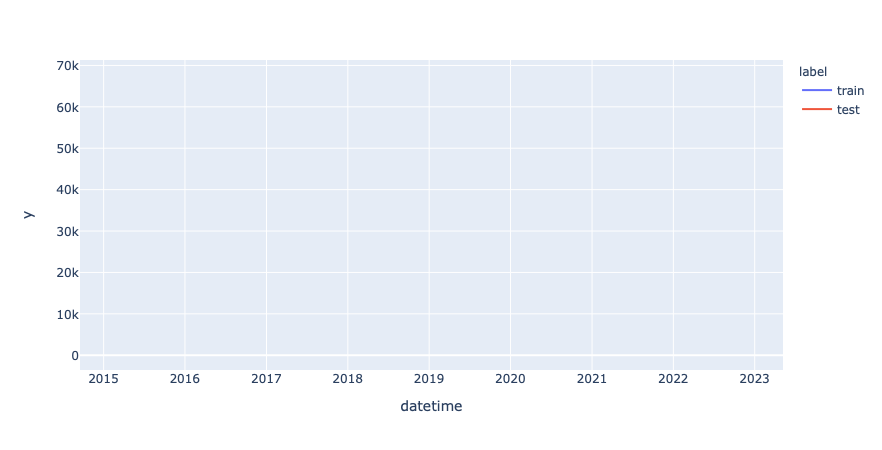

In [39]:
# Create traces
fig = px.line(df_forecast_lstm,x=df_forecast_lstm.index, y=df_forecast_lstm.value.values, color='label')

fig.show()

## Prophet

In [41]:
from prophet import Prophet

columns = ["ds", "y"]
df_prophet = pd.DataFrame(columns = columns)
df_prophet["ds"] = btc_data.index
df_prophet["y"] = btc_data.values

sc = MinMaxScaler()
df_prophet["y"] = sc.fit_transform(np.reshape(df_prophet.y.values, (-1, 1)))
df_prophet.head()

,ds,y
0,2014-09-17,0.004289
1,2014-09-18,0.004155
2,2014-09-19,0.003669
3,2014-09-20,0.003232
4,2014-09-21,0.003431


In [42]:
m = Prophet()
m.fit(df_prophet)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
# Python
future = m.make_future_dataframe(freq='s', periods=NB_VAL, include_history=True)
future.tail()

,ds
3151,2022-04-04 00:06:35
3152,2022-04-04 00:06:36
3153,2022-04-04 00:06:37
3154,2022-04-04 00:06:38
3155,2022-04-04 00:06:39


In [44]:
# Python
forecast_prophet = m.predict(future)
forecast_prophet.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3151,2022-04-04 00:06:35,0.858744,0.777136,0.997387,0.858744,0.858744,0.024533,0.024533,0.024533,-0.000392,-0.000392,-0.000392,0.024925,0.024925,0.024925,0.0,0.0,0.0,0.883277
3152,2022-04-04 00:06:36,0.858744,0.777080,0.995511,0.858744,0.858744,0.024533,0.024533,0.024533,-0.000392,-0.000392,-0.000392,0.024925,0.024925,0.024925,0.0,0.0,0.0,0.883277
3153,2022-04-04 00:06:37,0.858744,0.776813,0.995780,0.858744,0.858744,0.024533,0.024533,0.024533,-0.000392,-0.000392,-0.000392,0.024925,0.024925,0.024925,0.0,0.0,0.0,0.883277
3154,2022-04-04 00:06:38,0.858744,0.776268,0.995367,0.858744,0.858744,0.024533,0.024533,0.024533,-0.000392,-0.000392,-0.000392,0.024925,0.024925,0.024925,0.0,0.0,0.0,0.883277
3155,2022-04-04 00:06:39,0.858744,0.771211,0.988641,0.858744,0.858744,0.024533,0.024533,0.024533,-0.000392,-0.000392,-0.000392,0.024925,0.024925,0.024925,0.0,0.0,0.0,0.883277


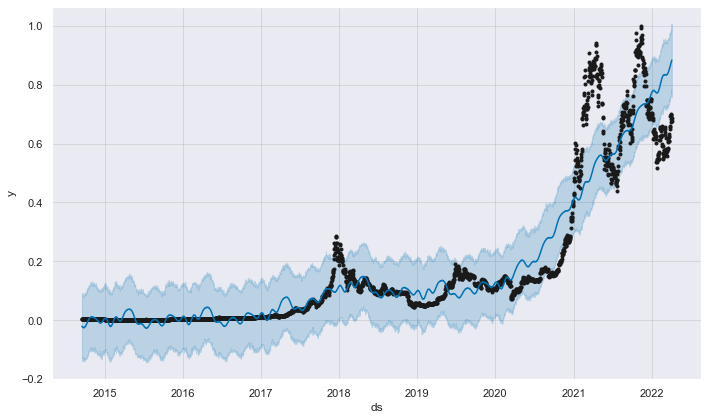

In [45]:
fig1 = m.plot(forecast_prophet)